In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive
numpyro.set_host_device_count(10)

import arviz as az
import seaborn as sns
import daft
from corner import corner

rng = random.PRNGKey(2023)


Suppose we have a cluster of $N$ stars each with distance $d_i$. The cluster will have a mean distance and spread $\mu_d$, $\sigma_d$. We also have apparent magnitudes $m_i$. This is a simplified version of Leistedt and Hogg (2017).

In [2]:
rng, *key = random.split(rng, 5)

num_obs = 20
mu_d = 10
sigma_d = 0.1

shape = (num_obs,)

d = mu_d + sigma_d * random.normal(key[0], shape=shape)
abs_mag = random.normal(key[1], shape=shape)
mag = abs_mag + 5 * np.log10(d)
par = 1 / d

sigma_mag = 0.1
sigma_par = 0.01

mag_obs = mag + sigma_mag * random.normal(key[2], shape=shape)
par_obs = par + sigma_par * random.normal(key[3], shape=shape)

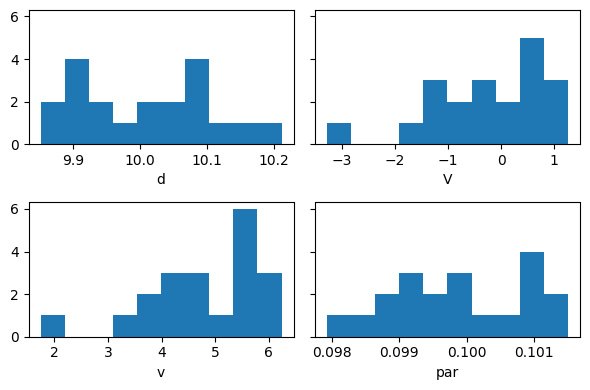

In [3]:
fig, axes = plt.subplots(2, 2, figsize=(6, 4), sharey=True)
params = [d, abs_mag, mag, par]
labels = ["d", "V", "v", "par"]

for i, ax in enumerate(axes.ravel()):
    ax.hist(params[i])
    ax.set_xlabel(labels[i])
fig.tight_layout()

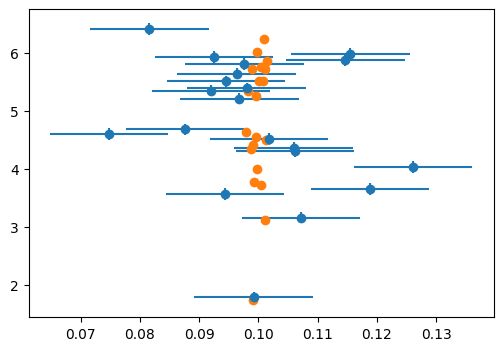

In [4]:
fig, ax = plt.subplots(figsize=(6, 4))

mag_obs = mag + sigma_mag * random.normal(key[2], shape=shape)
ax.errorbar(par_obs, mag_obs, xerr=sigma_par, yerr=sigma_mag, fmt="o")
ax.plot(par, mag, "o")

In [5]:
def simple_model(par_obs=None, mag_obs=None):
    d = numpyro.sample("d", dist.Uniform(0., 20.), sample_shape=shape)
    abs_mag = numpyro.sample("abs_mag", dist.Normal(0., 10.), sample_shape=shape)
    
    par = numpyro.deterministic("par", 1/d)
    mag = numpyro.deterministic("mag", abs_mag + 5.0 * jnp.log10(d))
    
    numpyro.sample("par_obs", dist.Normal(par, sigma_par), obs=par_obs)
    numpyro.sample("mag_obs", dist.Normal(mag, sigma_mag), obs=mag_obs)

In [6]:
sampler = NUTS(simple_model)
mcmc = MCMC(sampler, num_warmup=500, num_samples=1000, num_chains=10)

In [7]:
rng, key = random.split(rng)
mcmc.run(key, par_obs=par_obs, mag_obs=mag_obs)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [8]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
 abs_mag[0]     -1.63      0.26     -1.62     -2.06     -1.21   9234.42      1.00
 abs_mag[1]      0.11      0.27      0.12     -0.31      0.57   8821.95      1.00
 abs_mag[2]     -0.56      0.24     -0.55     -0.93     -0.16  12672.91      1.00
 abs_mag[3]      1.26      0.22      1.27      0.90      1.61  10983.95      1.00
 abs_mag[4]      0.51      0.25      0.51      0.09      0.91   9626.75      1.00
 abs_mag[5]      0.08      0.26      0.09     -0.33      0.50   9315.08      1.00
 abs_mag[6]      0.32      0.26      0.34     -0.10      0.75   6513.41      1.00
 abs_mag[7]     -3.29      0.24     -3.28     -3.68     -2.89  12189.17      1.00
 abs_mag[8]     -0.69      0.29     -0.67     -1.17     -0.23   6533.56      1.00
 abs_mag[9]     -0.50      0.25     -0.49     -0.88     -0.08  10797.82      1.00
abs_mag[10]     -0.50      0.20     -0.50     -0.83     -0.16  12263.54      1.00
abs_mag[11]    

In [9]:
coords = {"Star": np.arange(num_obs)}
dims = {
    "d": ["Star"], 
    "mag": ["Star"], 
    "abs_mag": ["Star"], 
    "par": ["Star"],
    "par_obs": ["Star"],
    "mag_obs": ["Star"]
}

samples_simple = mcmc.get_samples()
data_simple = az.from_numpyro(mcmc, coords=coords, dims=dims)
data_simple

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

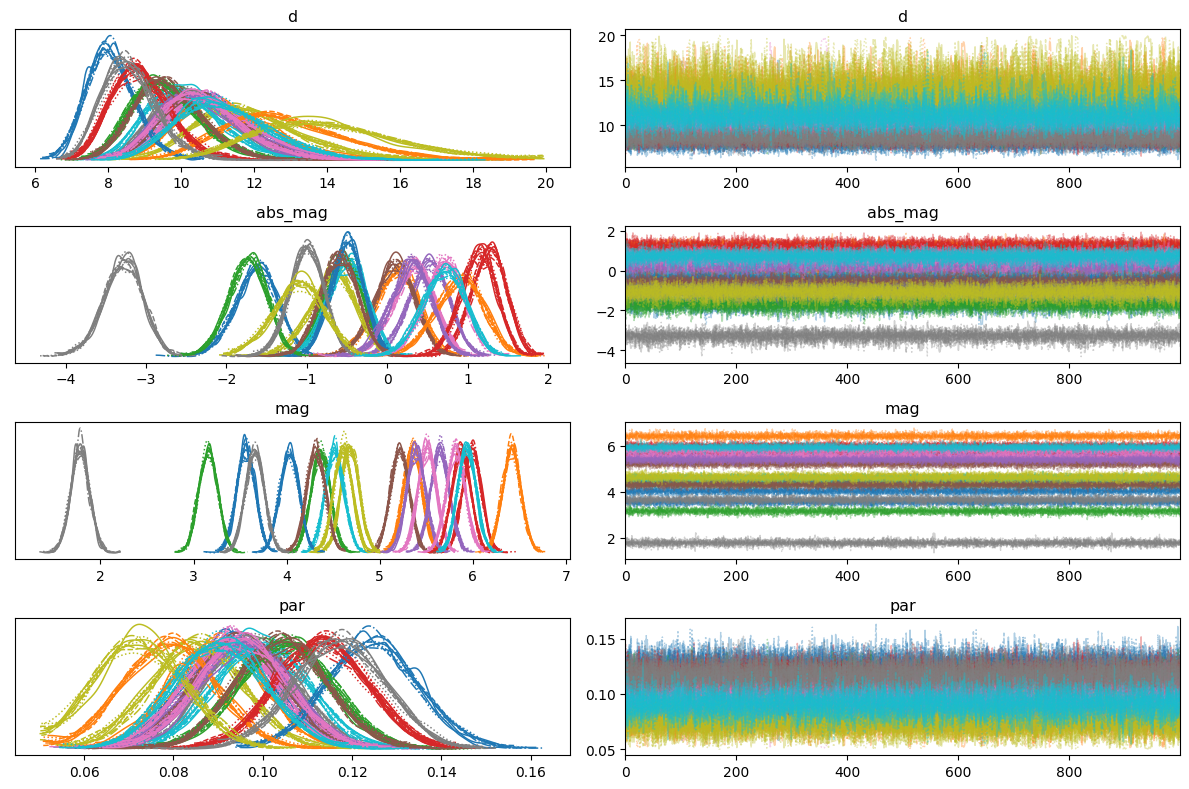

In [10]:
var_names = ["d", "abs_mag", "mag", "par"]
ax = az.plot_trace(data_simple, var_names=var_names)
plt.gcf().tight_layout()

In [11]:
def hierarchical_model(par_obs=None, mag_obs=None):
    mu_d = numpyro.sample("mu_d", dist.Uniform(0., 20.))
    sigma_d = numpyro.sample("sigma_d", dist.LogNormal(jnp.log(0.1), 1.0))
    # sigma_d = numpyro.deterministic("sigma_d", jnp.exp(log_sigma_d))
    _d = numpyro.sample("_d", dist.Normal(), sample_shape=shape)
    d = numpyro.deterministic("d", mu_d + sigma_d * _d)
    
    abs_mag = numpyro.sample("abs_mag", dist.Normal(0., 10.), sample_shape=shape)
    
    par = numpyro.deterministic("par", 1/d)
    mag = numpyro.deterministic("mag", abs_mag + 5.0 * jnp.log10(d))
    
    numpyro.sample("par_obs", dist.Normal(par, sigma_par), obs=par_obs)
    numpyro.sample("mag_obs", dist.Normal(mag, sigma_mag), obs=mag_obs)

In [12]:
sampler = NUTS(hierarchical_model, target_accept_prob=0.98)
mcmc = MCMC(sampler, num_warmup=500, num_samples=1000, num_chains=10)

In [13]:
rng, key = random.split(rng)
mcmc.run(key, par_obs=par_obs, mag_obs=mag_obs)

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [14]:
mcmc.print_summary()


                 mean       std    median      5.0%     95.0%     n_eff     r_hat
      _d[0]      0.10      0.97      0.11     -1.47      1.73  10959.33      1.00
      _d[1]      0.14      0.98      0.16     -1.40      1.81  12022.52      1.00
      _d[2]     -0.10      0.97     -0.10     -1.76      1.45  11102.50      1.00
      _d[3]     -0.26      0.99     -0.27     -1.81      1.45   8100.99      1.00
      _d[4]      0.08      0.98      0.09     -1.49      1.74  11895.07      1.00
      _d[5]      0.07      0.99      0.07     -1.61      1.63  12237.90      1.00
      _d[6]      0.09      0.98      0.09     -1.63      1.63  11357.06      1.00
      _d[7]      0.03      0.98      0.03     -1.58      1.59  12561.91      1.00
      _d[8]      0.22      0.97      0.22     -1.42      1.77   9427.22      1.00
      _d[9]     -0.03      0.98     -0.05     -1.59      1.67  11648.48      1.00
     _d[10]     -0.47      1.05     -0.48     -2.23      1.24   4380.41      1.00
     _d[11]    

In [15]:
dims["_d"] = ["Star"]

samples_hbm = mcmc.get_samples()
data_hbm = az.from_numpyro(mcmc, coords=coords, dims=dims)
data_hbm

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

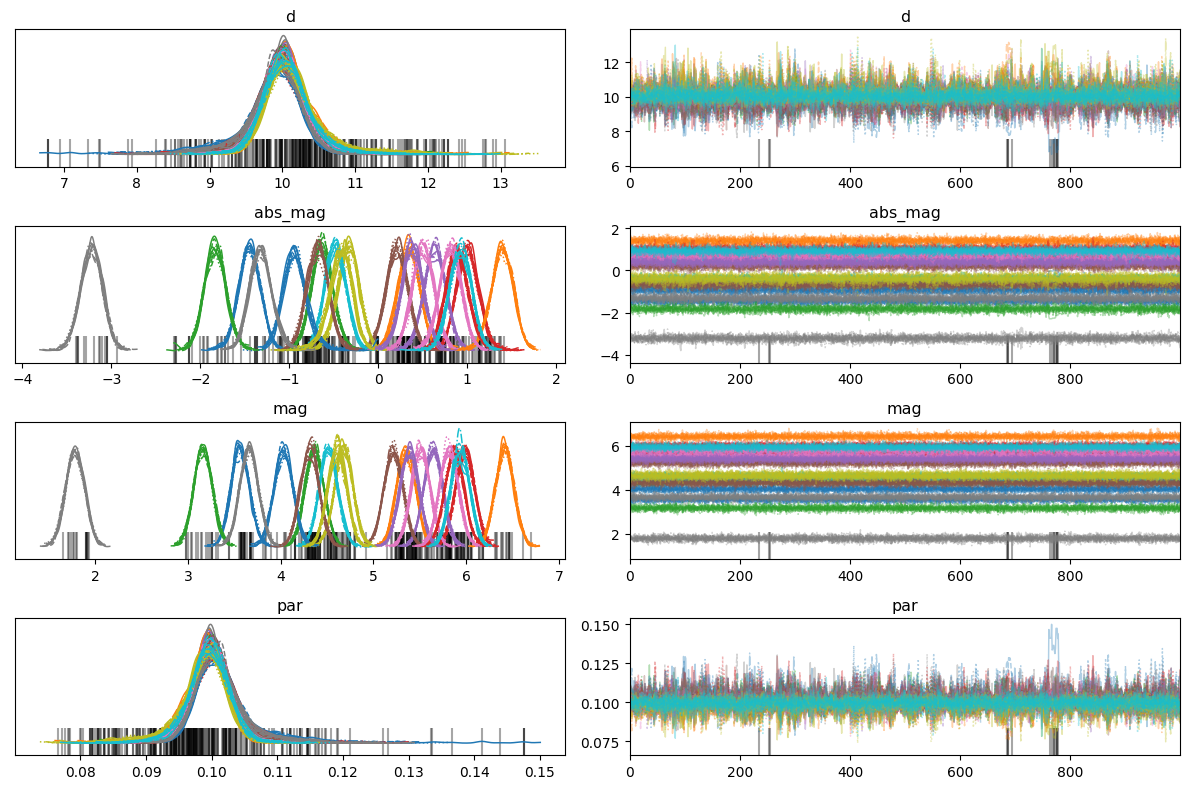

In [16]:
ax = az.plot_trace(data_hbm, var_names=var_names)
plt.gcf().tight_layout()

In [17]:
df = pd.concat(
    {
        "Simple": data_simple.posterior.to_dataframe(), 
        "HBM": data_hbm.posterior.to_dataframe()
    },
    names=["Model"]
).reset_index()
df.head()


,Model,chain,draw,Star,abs_mag,d,mag,par,_d,mu_d,sigma_d
0,Simple,0,0,0,-1.421803,9.632935,3.496990,0.103811,NaN,NaN,NaN
1,Simple,0,0,1,0.420788,10.382533,5.502305,0.096316,NaN,NaN,NaN
2,Simple,0,0,2,-0.528891,9.313428,4.316656,0.107372,NaN,NaN,NaN
3,Simple,0,0,3,1.482596,7.556942,5.874326,0.132329,NaN,NaN,NaN
4,Simple,0,0,4,0.263876,11.588322,5.583979,0.086294,NaN,NaN,NaN


In [18]:
def plot_summary(df, y, truth=None, ylabel=None, legend=True, axes=None):
    if axes is None:
        fig, axes = plt.subplots(1, 2, figsize=(6.4, 3.2), sharey=True,
                                gridspec_kw={"width_ratios": [3, 1], "wspace": 0.06})
    else:
        fig = plt.gcf()

    ax = sns.violinplot(
        df, x="Star", y=y, hue="Model", saturation=1.0,
        scale="width", split=True, linewidth=0., ax=axes[0]
    )
    
    if truth is not None:
        star = np.arange(num_obs)
        ax.plot(star, truth, ".k", label="Truth")
        # ax.legend()
    
    if not legend:
        ax.get_legend().remove()
    
    ax = sns.kdeplot(df, y=y, hue="Model", ax=axes[1], legend=legend)
    ax.set_xticks([])
    ax.set_xlabel(None)
    if ylabel is not None:
        for ax in axes:
            ax.set_ylabel(ylabel)

    return fig, axes

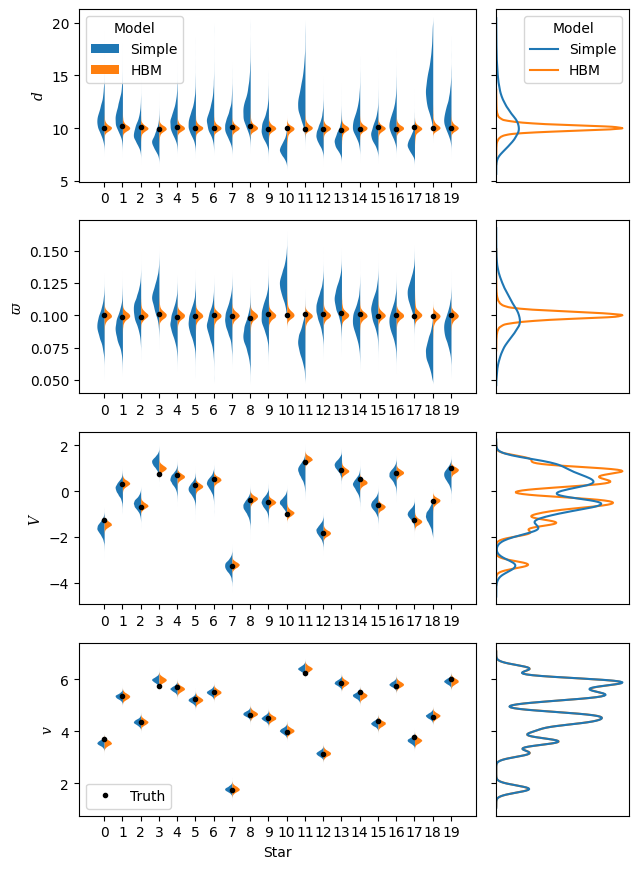

In [29]:
with plt.rc_context({
    "mathtext.fontset": "dejavuserif",
}):
    fig, axes = plt.subplots(4, 2, figsize=(6.4, 8.8), sharey="row",
                            gridspec_kw={"width_ratios": [3, 1]})

    ax0 = axes[-1]
    _, ax0 = plot_summary(df, "mag", truth=mag, ylabel=r"$v$", axes=ax0, legend=False)
    ax0[0].legend(handles=[ax0[0].get_lines()[-1]], loc="lower left")

    ax = axes[-2]
    ax[0].sharex(ax0[0])
    _, ax = plot_summary(df, "abs_mag", truth=abs_mag, ylabel=r"$V$", axes=ax, legend=False)
    ax[0].set_xlabel(None)

    ax = axes[-3]
    ax[0].sharex(ax0[0])
    _, ax = plot_summary(df, "par", truth=par, ylabel=r"$\varpi$", axes=ax, legend=False)
    ax[0].set_xlabel(None)

    ax = axes[-4]
    ax[0].sharex(ax0[0])
    _, ax = plot_summary(df, "d", truth=d, ylabel=r"$d$", axes=ax)
    ax[0].set_xlabel(None)

    fig.tight_layout()
    fig.savefig("../figures/hbm-results.pdf", format="pdf", dpi=300)

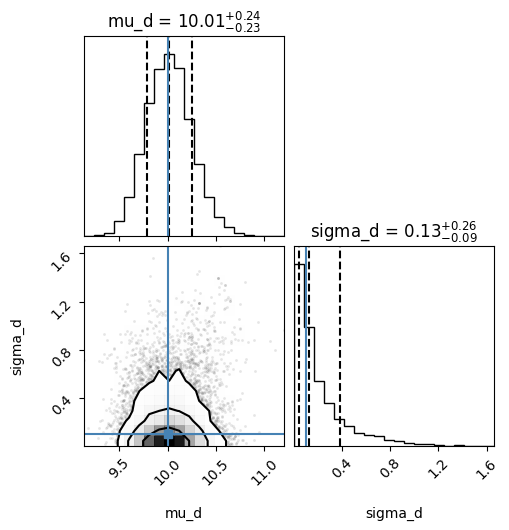

In [20]:
fig = corner(
    data_hbm, 
    var_names=["mu_d", "sigma_d"], 
    truths={"mu_d": mu_d, "sigma_d": sigma_d},
    show_titles=True,
    quantiles=[.16, .5, .84]
)

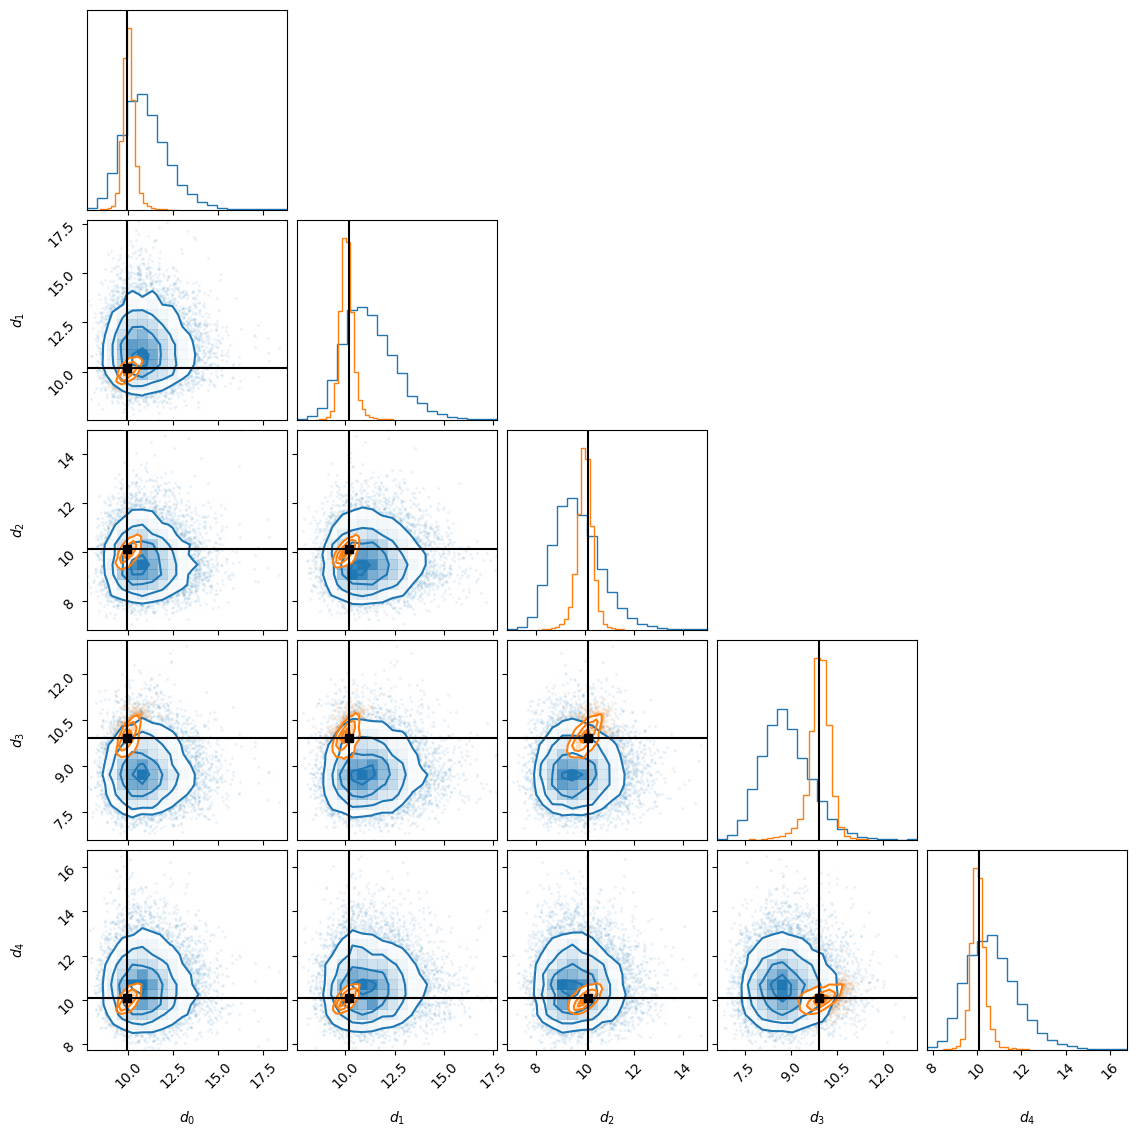

In [21]:
stars = np.arange(5)
var_names = ["d"]
labels = [f"$d_{i}$" for i in stars]
coords = {"Star": stars}

fig = corner(
    data_simple, 
    var_names=var_names,
    labels=labels,
    coords=coords,
    color="C0",
)

fig = corner(
    data_hbm, 
    var_names=var_names,
    labels=labels,
    coords=coords,
    color="C1",
    truths={"d": d[stars]},
    truth_color="k",
    fig=fig
)

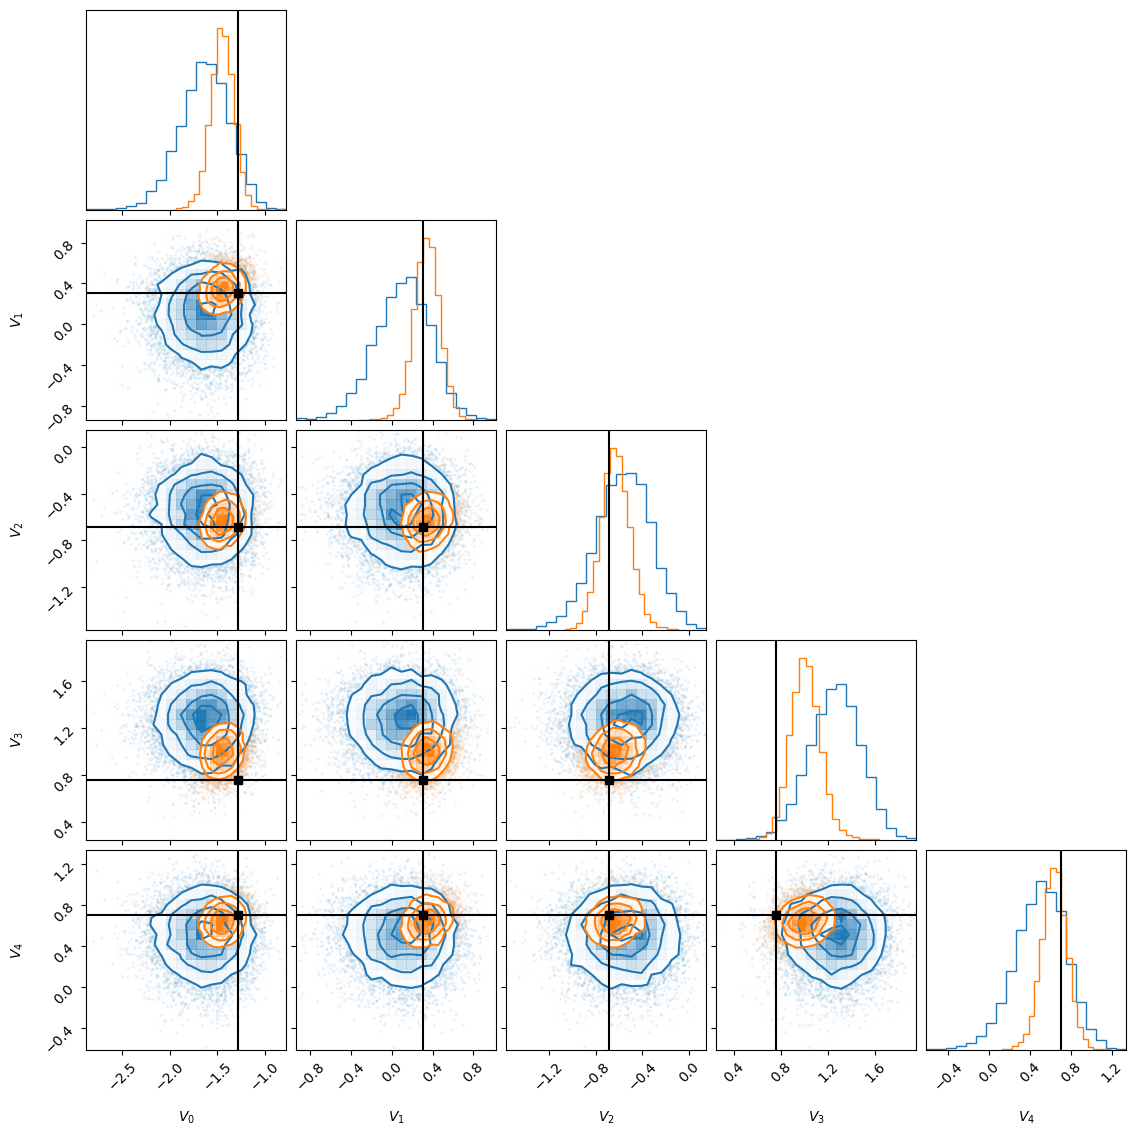

In [22]:
stars = np.arange(5)
var_names = ["abs_mag"]
labels = [f"$V_{i}$" for i in stars]
coords = {"Star": stars}

fig = corner(
    data_simple, 
    var_names=var_names,
    labels=labels,
    coords=coords,
    color="C0",
)

fig = corner(
    data_hbm, 
    var_names=var_names,
    labels=labels,
    coords=coords,
    color="C1",
    truths={"abs_mag": abs_mag[stars]},
    truth_color="k",
    fig=fig
)

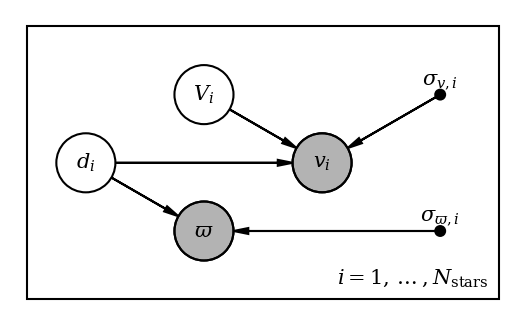

In [30]:
ux = 1
uy = 1 / np.sqrt(3)

with plt.rc_context({
    "mathtext.fontset": "dejavuserif",
}):
    # Instantiate the PGM.
    pgm = daft.PGM()

    # Parameters
    pgm.add_node("d", r"$d_i$", 0, 0)
    pgm.add_node("abs_mag", r"$V_i$", ux, uy)
    pgm.add_node("mag", r"$v_i$", 2*ux, 0, observed=True)
    pgm.add_node("par", r"$\varpi$", ux, -uy, observed=True)

    # Uncertainties
    pgm.add_node("sigma_mag", r"$\sigma_{v,i}$", 3*ux, uy, fixed=True)
    pgm.add_node("sigma_par", r"$\sigma_{\varpi,i}$", 3*ux, -uy, fixed=True)


    pgm.add_edge("d", "mag")
    pgm.add_edge("d", "par")
    pgm.add_edge("abs_mag", "mag")
    pgm.add_edge("sigma_mag", "mag")
    pgm.add_edge("sigma_par", "par")

    pgm.add_plate([-ux/2, -2*uy, 4*ux, 4*uy], label=r"$i=1,\dots,N_\mathrm{stars}$", position='bottom right')
    pgm.render(dpi=150)
    pgm.savefig("../figures/simple-pgm.pdf", format="pdf", dpi=300)

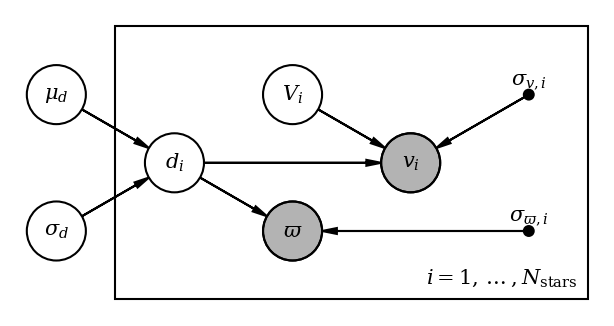

In [31]:
# Instantiate the PGM.
with plt.rc_context({
    "mathtext.fontset": "dejavuserif",
}):
    pgm = daft.PGM()

    # Hyperparameters
    pgm.add_node("mu_d", r"$\mu_d$", -ux, uy)
    pgm.add_node("sigma_d", r"$\sigma_d$", -ux, -uy)

    # Parameters
    pgm.add_node("d", r"$d_i$", 0, 0)
    pgm.add_node("abs_mag", r"$V_i$", 1, uy)
    pgm.add_node("mag", r"$v_i$", 2*ux, 0, observed=True)
    pgm.add_node("par", r"$\varpi$", ux, -uy, observed=True)

    # Uncertainties
    pgm.add_node("sigma_mag", r"$\sigma_{v,i}$", 3*ux, uy, fixed=True)
    pgm.add_node("sigma_par", r"$\sigma_{\varpi,i}$", 3*ux, -uy, fixed=True)


    pgm.add_edge("mu_d", "d")
    pgm.add_edge("sigma_d", "d")

    pgm.add_edge("d", "mag")
    pgm.add_edge("d", "par")
    pgm.add_edge("abs_mag", "mag")
    pgm.add_edge("sigma_mag", "mag")
    pgm.add_edge("sigma_par", "par")

    pgm.add_plate([-ux/2, -2*uy, 4*ux, 4*uy], label=r"$i=1,\dots,N_\mathrm{stars}$", position='bottom right')
    pgm.render(dpi=150)
    pgm.savefig("../figures/hbm-pgm.pdf", format="pdf", dpi=300)

<Axes: >

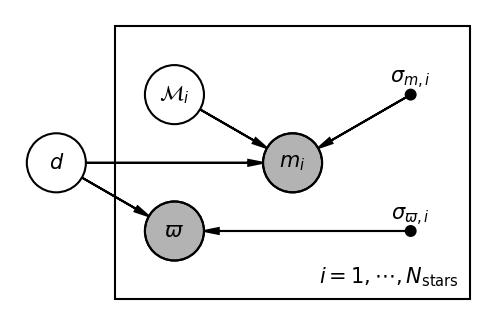

In [185]:
# Instantiate the PGM.
pgm = daft.PGM()

# Parameters
pgm.add_node("d", r"$d$", 0, 0)
pgm.add_node("abs_mag", r"$\mathcal{M}_i$", ux, uy)
pgm.add_node("mag", r"$m_i$", 2*ux, 0, observed=True)
pgm.add_node("par", r"$\varpi$", ux, -uy, observed=True)

# Uncertainties
pgm.add_node("sigma_mag", r"$\sigma_{m,i}$", 3*ux, uy, fixed=True)
pgm.add_node("sigma_par", r"$\sigma_{\varpi,i}$", 3*ux, -uy, fixed=True)

pgm.add_edge("d", "mag")
pgm.add_edge("d", "par")
pgm.add_edge("abs_mag", "mag")
pgm.add_edge("sigma_mag", "mag")
pgm.add_edge("sigma_par", "par")

pgm.add_plate([ux/2, -2*uy, 3*ux, 4*uy], label=r"$i=1,\cdots,N_\mathrm{stars}$", 
              position='bottom right')
pgm.render(dpi=150)